## Model seed test for better $\mu$ values
December 8, 2025

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from imports import *
datadir, dirname, device, device0 = init_vars('simcloud', GPU=1)

2025 December 9: ifernand running on sc
Device assigned: cuda:1
Loaded additional packages:
  scd spu readout_fit BC 
Datadir: /data/Antolik/
Dirname: /home/ifernand/


## Load Data

In [2]:
start    = time()
data     = scd.SimCloudData(down_sample=3, num_lags=11)
end      = time()

print('CPU Time', end-start, 'sec')

CPU Time 56.514641523361206 sec


In [3]:
start     = time()
test_data = scd.SimCloudData(filename='cloud_TEST_data_stim_dim120_spike_time_sqrad_0.3.hdf5', down_sample=3, num_lags=11, test=True)
end       = time()

print('CPU Time', end-start, 'sec')

CPU Time 17.4683358669281 sec


In [4]:
test_robs = test_data.repeat_robs
test_dfs = test_data.repeat_dfs
print(test_robs.shape)
print(test_dfs.shape)

(30000, 10, 1491)
(30000, 10, 1491)


In [5]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

# Load baseline LL
GLM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GLM_R2.npy')
GQM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GQM_R2.npy')

In [6]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [7]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [8]:
mu0s = data.mu0s
num_lags = data.num_lags
L  = data.stim_dims[1]
NC = data.NC
NT = data.NT
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

num_lags = 11
L = 40
Number of cells 1491
Number of time points 480000


In [9]:
# cell key
cell_key = data.cell_key

# integer cell key
int_key = np.zeros(NC)
int_key[L4_exc_idx] = 1
int_key[L4_inh_idx] = 2
int_key[L23_exc_idx] = 3
int_key[L23_inh_idx] = 4

# cell key dict
key_dict = {}
key_dict['L4 Exc'] = 1
key_dict['L4 Inh'] = 2
key_dict['L2/3 Exc'] = 3
key_dict['L2/3 Inh'] = 4

colors = ['tab:blue', 'tab:cyan', 'tab:red', 'm']

In [10]:
angles = np.arange(0, 180, 30).astype(int)
angles

array([  0,  30,  60,  90, 120, 150])

## Layer 4 Model for LGN Units

In [11]:
LGN_cnn = NDN.load_model('models/1016_three_layer_model_ORICONV_CNN_L4_None_maxreg.ndn')
LGN_cnn.block_sample = True
LGN_cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


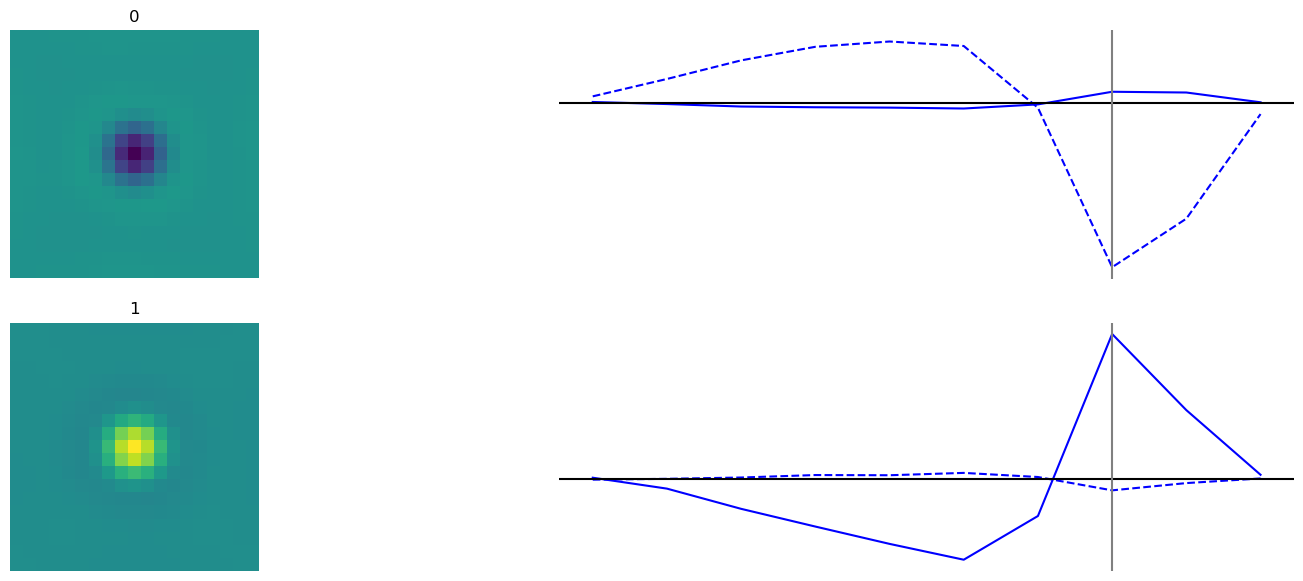

In [12]:
LGN_cnn.plot_filters()

In [13]:
LGN_filt = deepcopy(LGN_cnn.networks[0].layers[0].weight.data).reshape(LGN_cnn.networks[0].layers[0].filter_dims+[2])
LGN_filt.shape

torch.Size([1, 19, 19, 10, 2])

In [14]:
x = 5
LGN_filt_crop = LGN_filt[:,x:-x, x:-x,:,:]
LGN_filt_crop.shape

torch.Size([1, 9, 9, 10, 2])

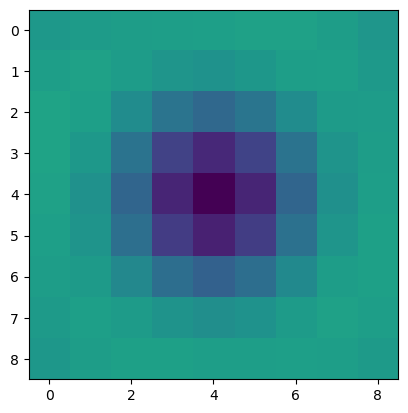

In [15]:
imagesc(LGN_filt_crop[0,:,:,-2,0].numpy(),balanced=True)

In [16]:
LGN_filt_crop = LGN_filt_crop.reshape([9*9*10,2])
LGN_filt_crop.shape

torch.Size([810, 2])

## Ori CNN

In [17]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.001, early_stopping_patience=10, max_epochs=200,
    optimize_graph=False, weight_decay=0.01, accumulate_grad_batches=5)
adam_pars['device'] = device

In [18]:
#=====From Scratch Model=====
Treg0 = 0.0001
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.003 # d2/dx
Creg1 = 1e-11 # center

MaxReg = 0.001

NQ = len(angles)

fws = [9, 19, 1, 1]
num_subs = [2,16,12,12]

# LGN LAYER
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
    padding='same', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2t':Treg0, 'd2x':Xreg0, 'center': Creg0} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], num_inh=num_subs[1]//2,
        filter_width=fws[1], NLtype='relu', norm_type=1,
        bias=False, output_norm='batch', window='hamming', padding='same', initialize_center=True, 
        reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

# TIME SHIFT LAYER
clayersQ.append(TimeShiftLayer.layer_dict())

# REST
for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], num_inh=num_subs[ii]//2, 
        bias=False, norm_type=1, filter_width=fws[ii], NLtype='relu',
        output_norm='batch', initialize_center=True,
        angles=angles) )
    
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

In [19]:
nitter = 4
cnn_list = []
#R2_list = np.zeros((nitter,NC))
for i in range(2,nitter):
    seed = 100+i
    cnn = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poissonL', seed=seed)
    # Network 0: fix LGN filters
    cnn.networks[0].layers[0].weight.data = LGN_filt_crop
    cnn.networks[0].layers[0].set_parameters(val=False)
    # Network 1: set mu values
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].layers[0].fit_mus(True)
    cnn.networks[1].layers[0].sample_mode = 'bilinear'
    cnn.networks[1].layers[0].degrees2mu(V1_thetas, continuous=False)
    cnn.networks[1].layers[0].fit_Qmus(False)
    cnn.networks[1].layers[0].Qsample_mode = 'nearest'
    cnn.block_sample = True
    cnn.loss_module.unit_weighting = True

    model_name = cnn.model_name

    now = datetime.datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S_")
    
    start = time()
    cnn.fit(data, **adam_pars, verbose=False)
    end = time()
    cnn.save_model('models/fit_mu_seed_test_12-8-25/'+filename_timestamp+model_name+'_fitting_mu_seed'+str(seed)+'.ndn')
    test_pred = cnn.predictions(test_data, data_inds=np.arange(test_data.NB), batch_size=1, num_lags=num_lags, device=device).detach().cpu().numpy()
    R2 = spu.comp_test_R2(test_robs, test_dfs, test_pred)
    #R2_list[i,:] = R2
    print('MODEL', i+1)
    print('Train time:', end-start, 'sec')
    print('Mean R2:', np.mean(R2))
    print('Max R2:', np.max(R2))
    print(' ')

  Note: changing sample_mode to bilinear
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/fit_mu_seed_test_12-8-25/2025-12-09_17-21-34_NDN491_Q5_R1_fitting_mu_seed102.ndn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.41it/s]


MODEL 3
Train time: 20458.505788087845 sec
Mean R2: 0.4331135687906073
Max R2: 0.7264815526377836
 
  Note: changing sample_mode to bilinear
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/fit_mu_seed_test_12-8-25/2025-12-09_23-02-45_NDN491_Q5_R1_fitting_mu_seed103.ndn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.30it/s]


MODEL 4
Train time: 27044.463005065918 sec
Mean R2: 0.4327052866682769
Max R2: 0.7368612523680999
 


## GQMs

In [47]:
all_gqms = np.load('data/2-28_update_all_neuron_GQM_weights_sqrad_0.3_.pkl', allow_pickle=True)
all_gqms.shape
#V1_gqms = all_gqms[V1_idx, :, :, :, :]
#V1_gqms.shape

(1491, 60, 60, 11, 3)

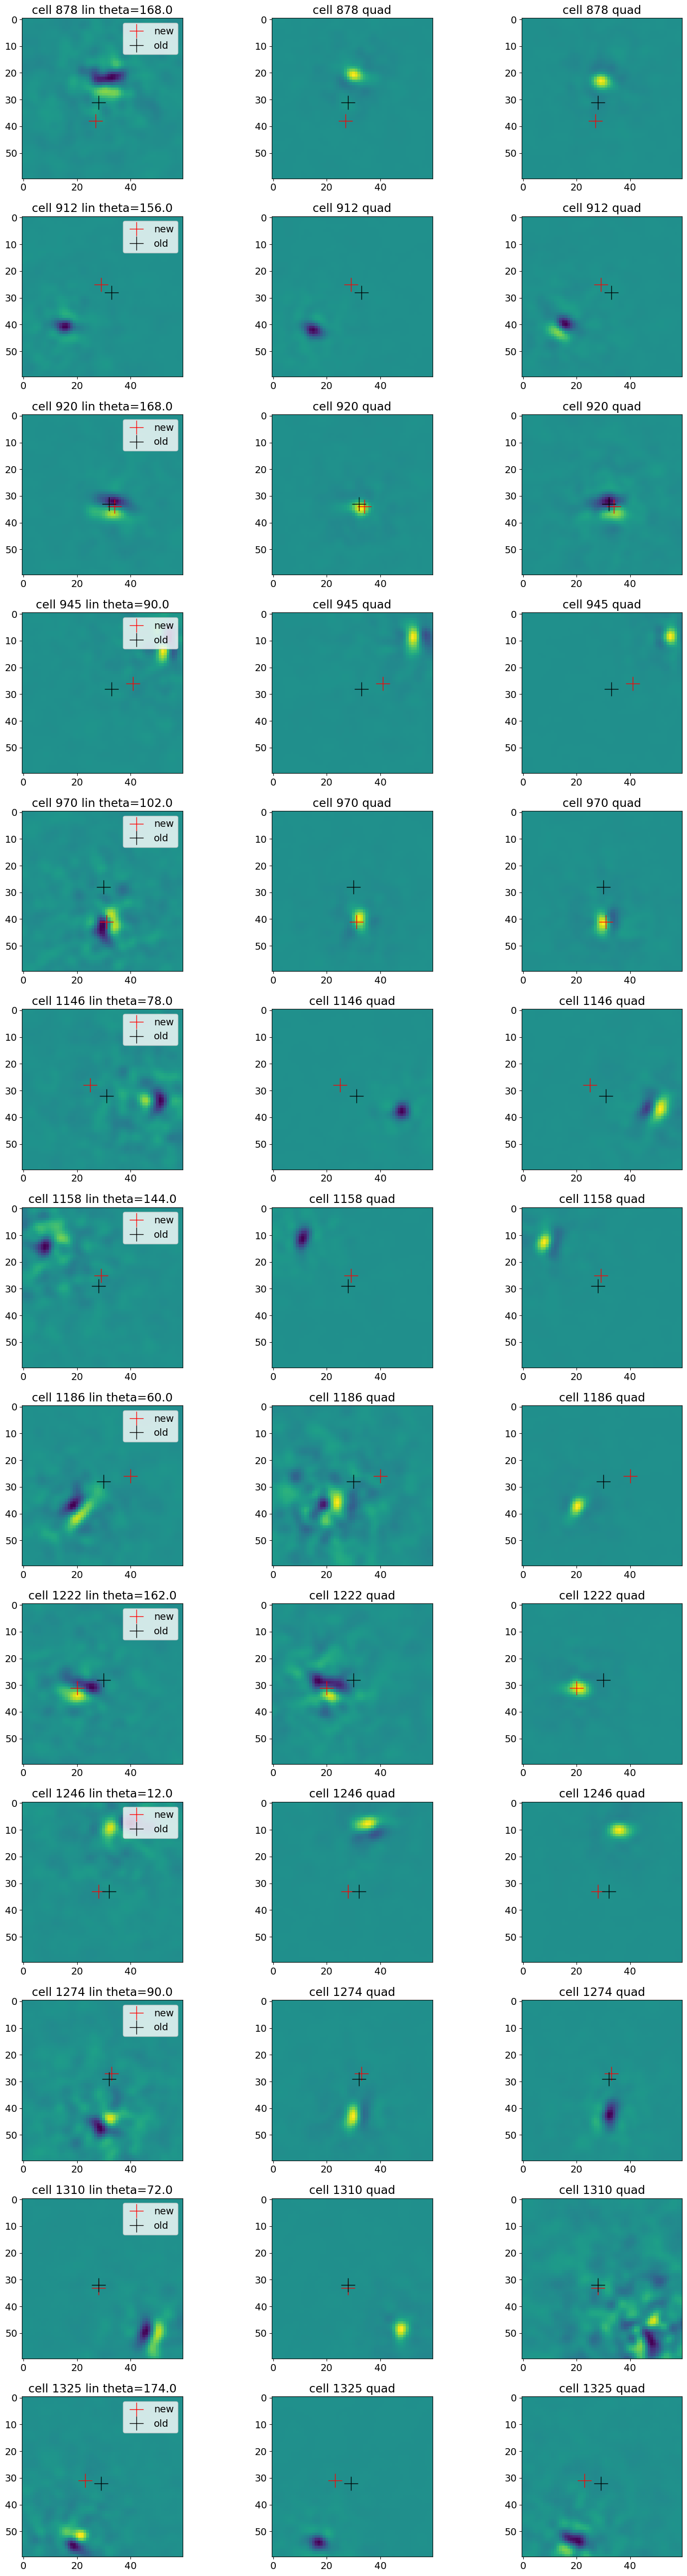

In [50]:
plt.rcParams.update({'font.size': 14})
ss(len(bad_L23_exc_cells),3)
k = 1
for i in range(len(bad_L23_exc_cells)):
    j = bad_L23_exc_cells[i]
    plt.subplot(len(bad_L23_exc_cells),3,k)
    imagesc(all_gqms[j,:,:,-2,0], balanced=True)
    plt.plot(new_xy[j,0],new_xy[j,1], '+', label='new', color='red', markersize=20)
    plt.plot(old_xy[j,0],old_xy[j,1], '+', label='old', color='black', markersize=20)
    plt.title('cell '+str(j)+' lin theta='+str(V1_thetas[j]))
    plt.legend()
    k += 1
    plt.subplot(len(bad_L23_exc_cells),3,k)
    imagesc(all_gqms[j,:,:,-2,1], balanced=True)
    plt.plot(new_xy[j,0],new_xy[j,1], '+', label='new', color='red', markersize=20)
    plt.plot(old_xy[j,0],old_xy[j,1], '+', label='old', color='black', markersize=20)
    plt.title('cell '+str(j)+' quad')
    k += 1
    plt.subplot(len(bad_L23_exc_cells),3,k)
    imagesc(all_gqms[j,:,:,-2,2], balanced=True)
    plt.plot(new_xy[j,0],new_xy[j,1], '+', label='new', color='red', markersize=20)
    plt.plot(old_xy[j,0],old_xy[j,1], '+', label='old', color='black', markersize=20)
    plt.title('cell '+str(j)+' quad')
    k += 1
plt.tight_layout()
plt.show()

## Model Comparison

In [23]:
model_names = ['models/fit_mu_seed_test_12-8-25/2025-12-08_16-38-52_NDN491_Q5_R1_fitting_mu_seed100.ndn',
               'models/fit_mu_seed_test_12-8-25/2025-12-09_10-10-51_NDN491_Q5_R1_fitting_mu_seed101.ndn',
               'models/fit_mu_seed_test_12-8-25/2025-12-09_17-21-34_NDN491_Q5_R1_fitting_mu_seed102.ndn',
               'models/fit_mu_seed_test_12-8-25/2025-12-09_23-02-45_NDN491_Q5_R1_fitting_mu_seed103.ndn']
NM = len(model_names)

In [24]:
cnn_list = []
for i in range(NM):
    cnn = NDN.load_model(model_names[i])
    cnn.eval()
    cnn.block_sample = True
    cnn.loss_module.unit_weighting = True
    cnn_list.append(cnn)

In [25]:
R2_list = np.zeros((NM,NC))
R2_GQM_diff = np.zeros((NM,NC))
for i in range(NM):
    test_pred = cnn_list[i].predictions(test_data, data_inds=np.arange(test_data.NB), batch_size=1, num_lags=num_lags, device=device).detach().cpu().numpy()
    R2 = spu.comp_test_R2(test_robs, test_dfs, test_pred)
    R2_list[i,:] = R2.copy()
    R2_GQM_diff[i,:] = R2.copy() - GQM_R2.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.45it/s]


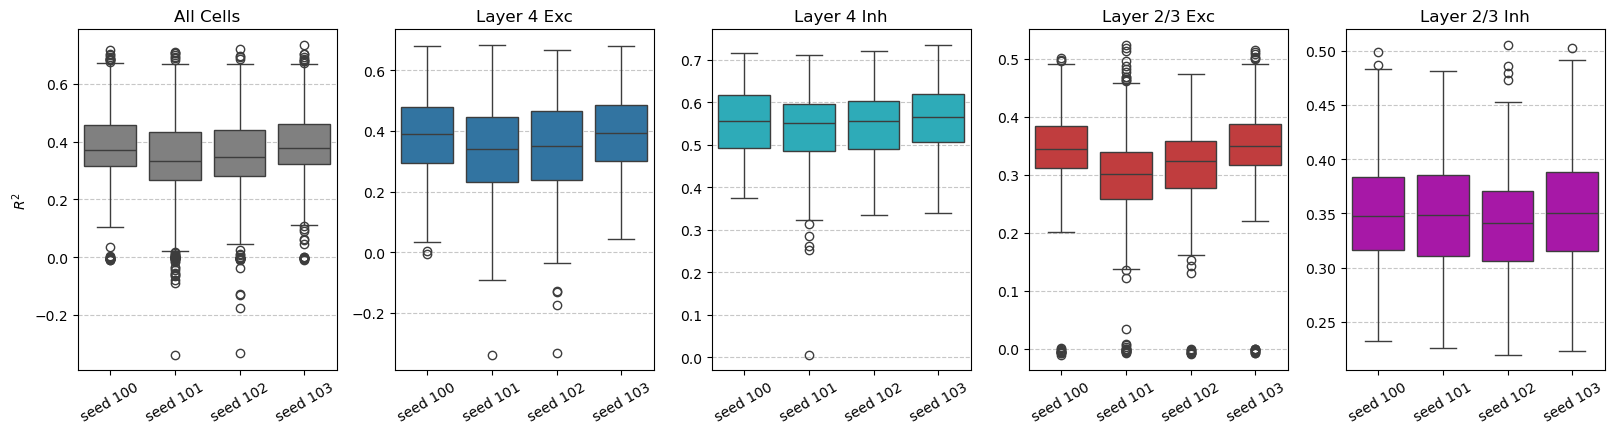

In [26]:
spu.R2_box_plot(R2_list, ['seed 100', 'seed 101', 'seed 102', 'seed 103'], cell_idx_dict, colors, rotation=30)
plt.show()

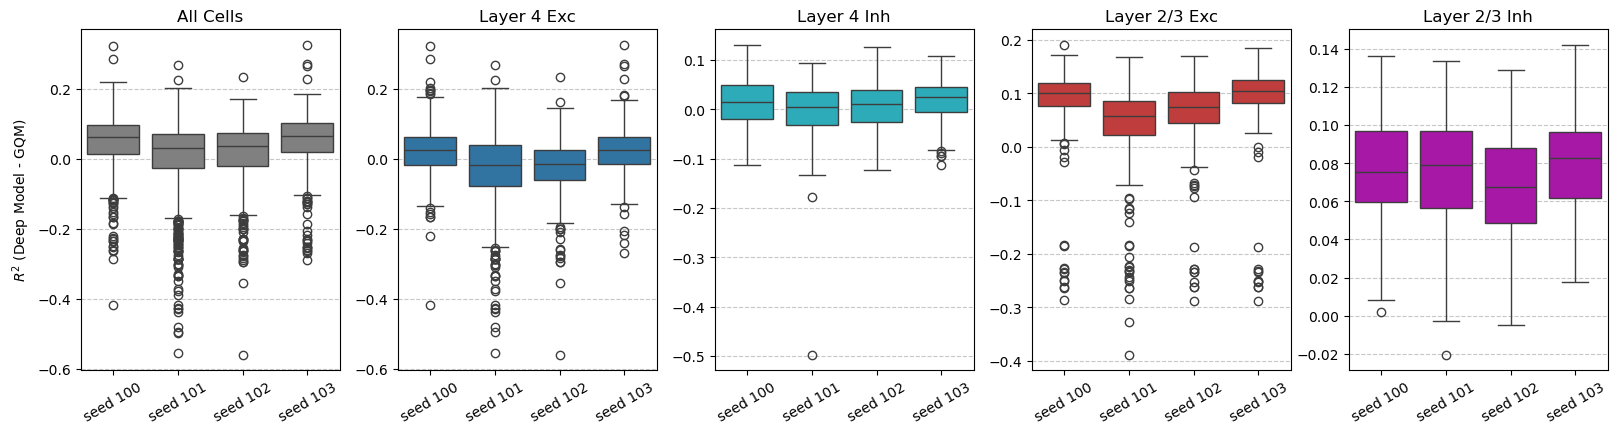

In [27]:
spu.R2_box_plot(R2_GQM_diff, ['seed 100', 'seed 101', 'seed 102', 'seed 103'], cell_idx_dict, colors, ylabel='$R^2$ (Deep Model - GQM)', rotation=30)
plt.show()

In [28]:
for i in range(NM):
    print(np.where(R2_GQM_diff[i,:]<=0.00)[0].shape)

(299,)
(526,)
(464,)
(250,)


In [29]:
for i in range(NM):
    print(np.where(R2_GQM_diff[i,L4_exc_idx]<=0.00)[0].shape)

(212,)
(356,)
(346,)
(185,)


In [30]:
for i in range(NM):
    print(np.where(R2_GQM_diff[i,L23_exc_idx]<=0.00)[0], np.where(R2_GQM_diff[i,L23_exc_idx]<=0.00)[0].shape)

[ 88 112 118 126 151 176 256 352 364 392 452 483 516 531] (14,)
[ 10  11  23  26  38  39  41  49  51  54  65  83  84 102 112 118 141 142
 148 151 166 191 195 226 233 237 250 253 254 257 263 266 271 275 280 282
 286 293 295 321 337 338 344 345 352 364 372 373 374 375 381 383 384 391
 392 400 415 418 421 428 429 441 447 452 461 471 480 481 483 490 491 499
 501 506 510 516 518 519 525 528 531] (81,)
[ 61  62  69 103 118 126 146 151 153 167 173 176 184 187 227 261 321 323
 328 329 331 352 359 364 375 385 392 404 405 420 452 483 506 516 526 528
 531] (37,)
[ 84 118 126 151 176 352 364 392 428 452 480 516 531] (13,)


In [45]:
bad_L23_exc_cells = len(L4_exc_idx+L4_inh_idx) + np.where(R2_GQM_diff[-1,L23_exc_idx]<=0.00)[0]
bad_L23_exc_cells

array([ 878,  912,  920,  945,  970, 1146, 1158, 1186, 1222, 1246, 1274,
       1310, 1325])

In [49]:
cnn = deepcopy(cnn_list[-1])
new_mu0s = deepcopy(cnn.networks[1].layers[0].mu.data).detach().cpu().numpy()
new_sigma = deepcopy(cnn.networks[1].layers[0].sigma.data).detach().cpu().numpy()
new_mu0s.shape
new_xy = utils.mu2pixel(new_mu0s, L=60)
old_xy = utils.mu2pixel(mu0s, L=60)
new_xy.shape, old_xy.shape

((1491, 2), (1491, 2))

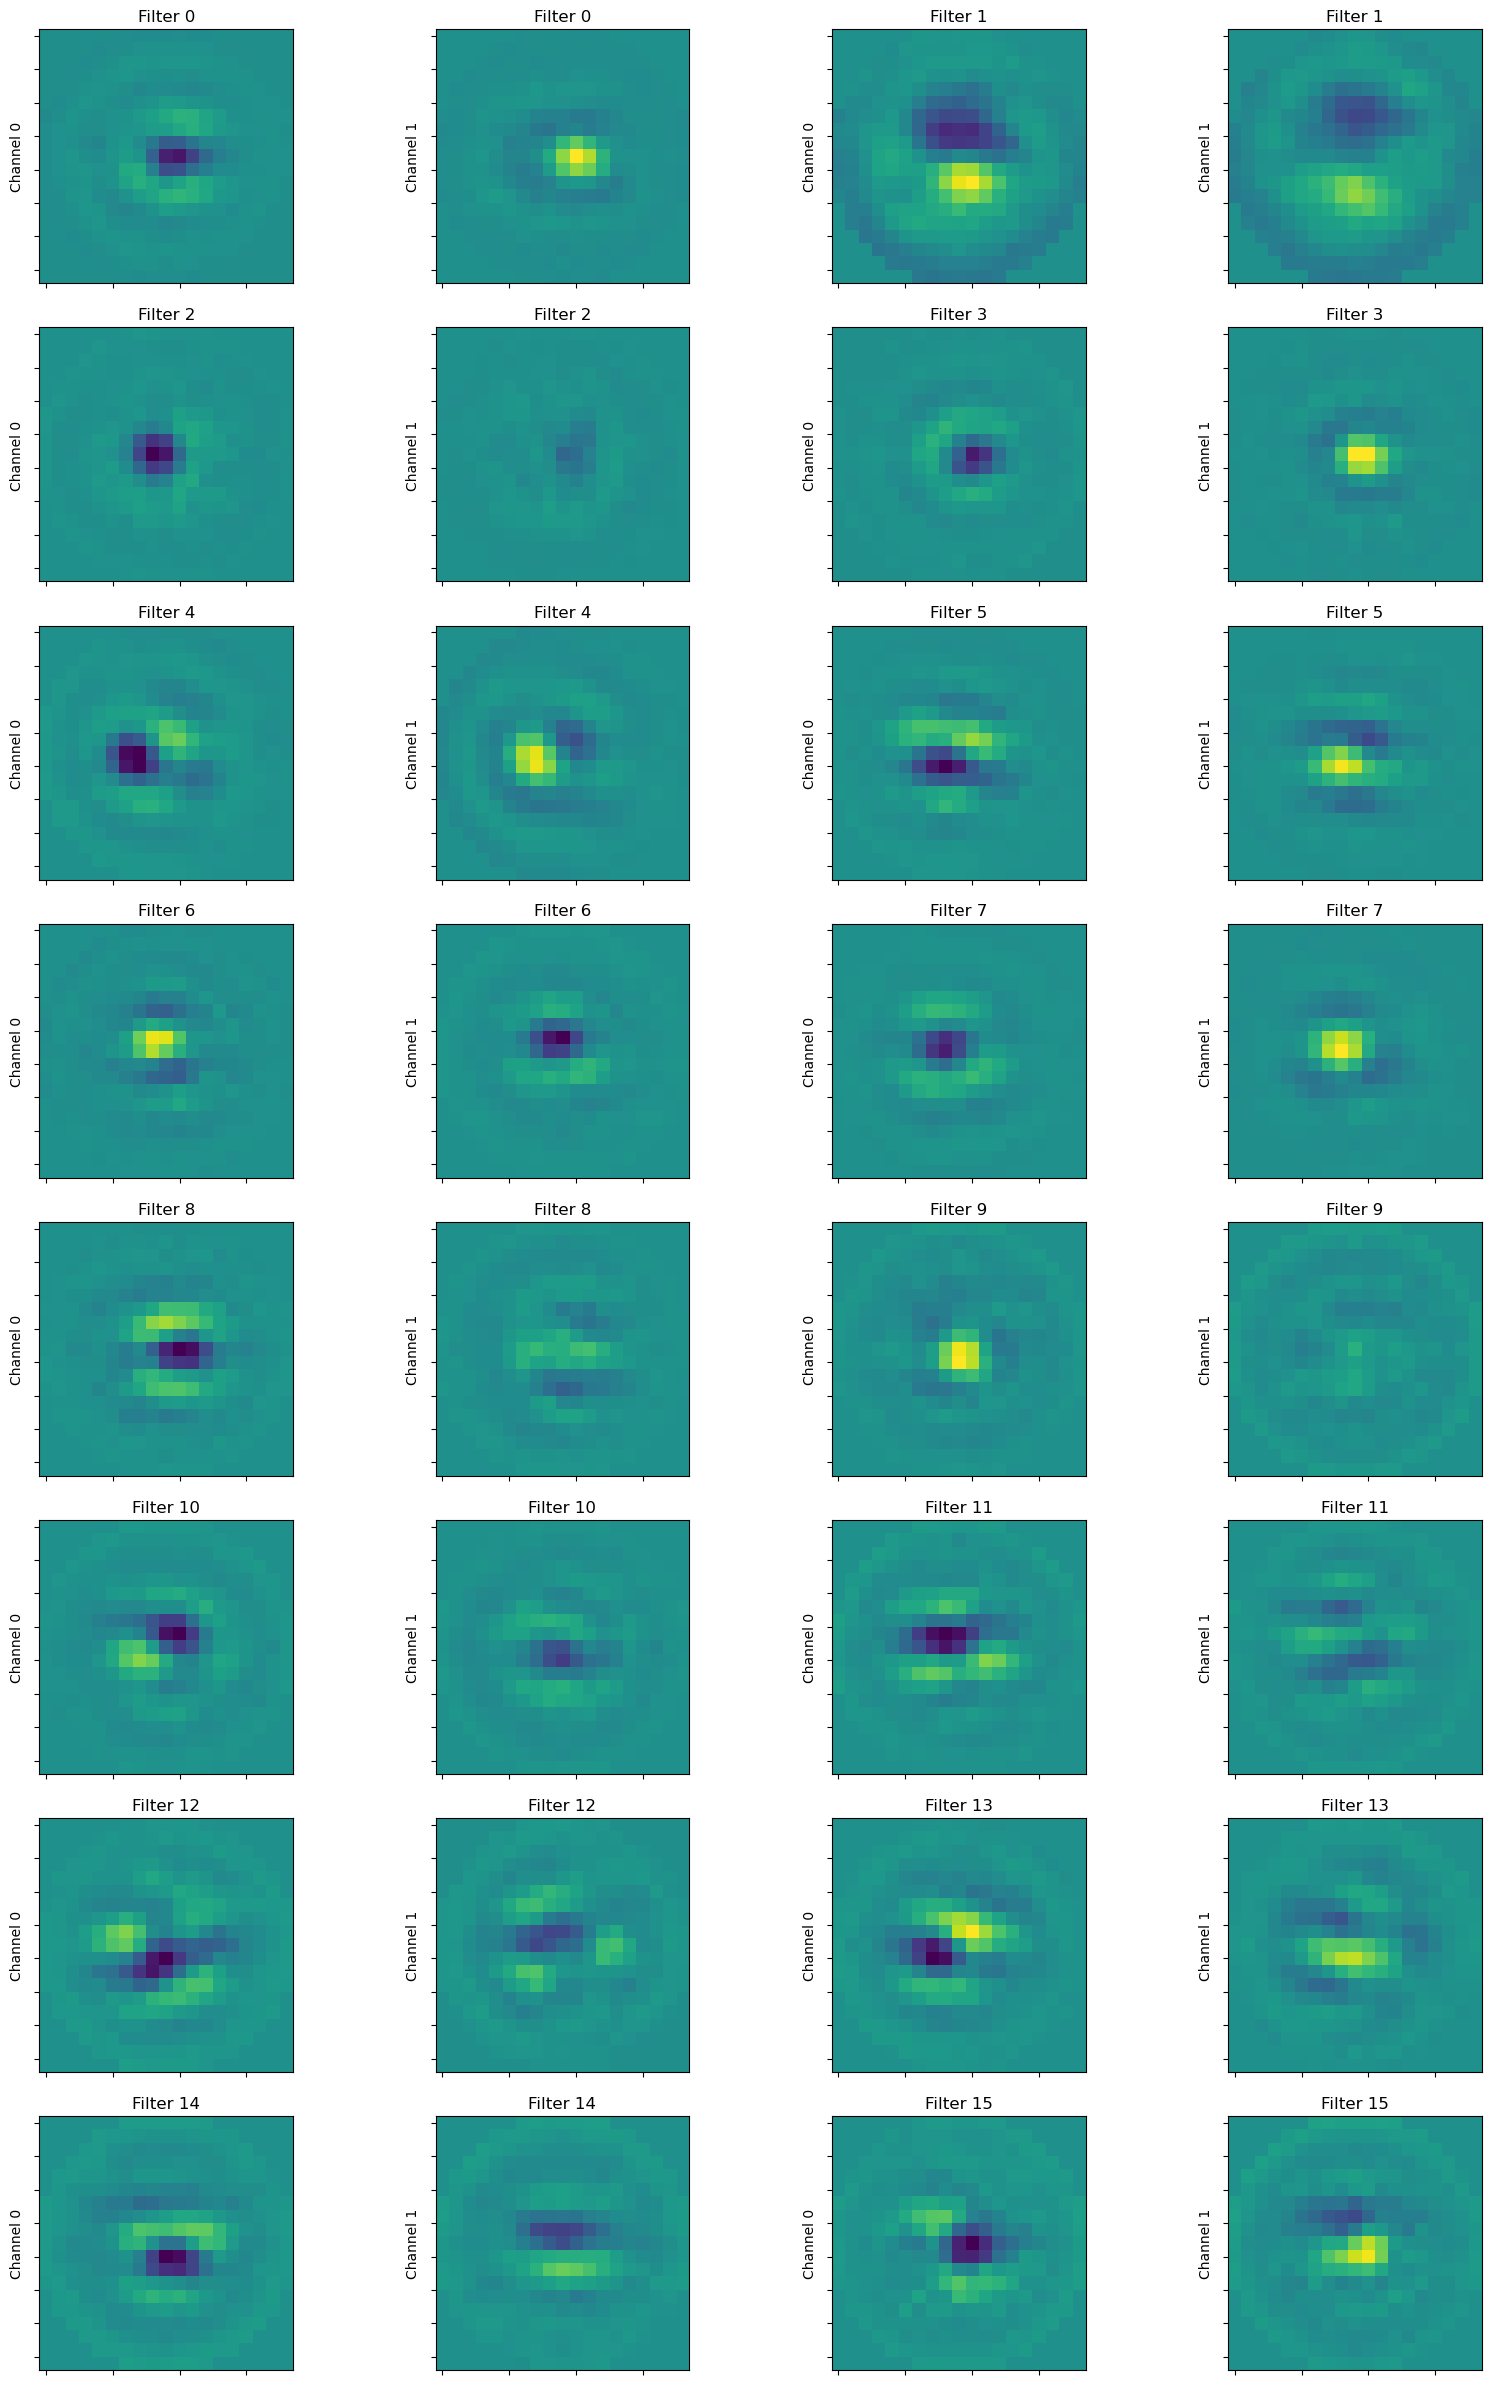

In [38]:
cnn_list[0].plot_filters(ffnet_target=0,layer_target=1)

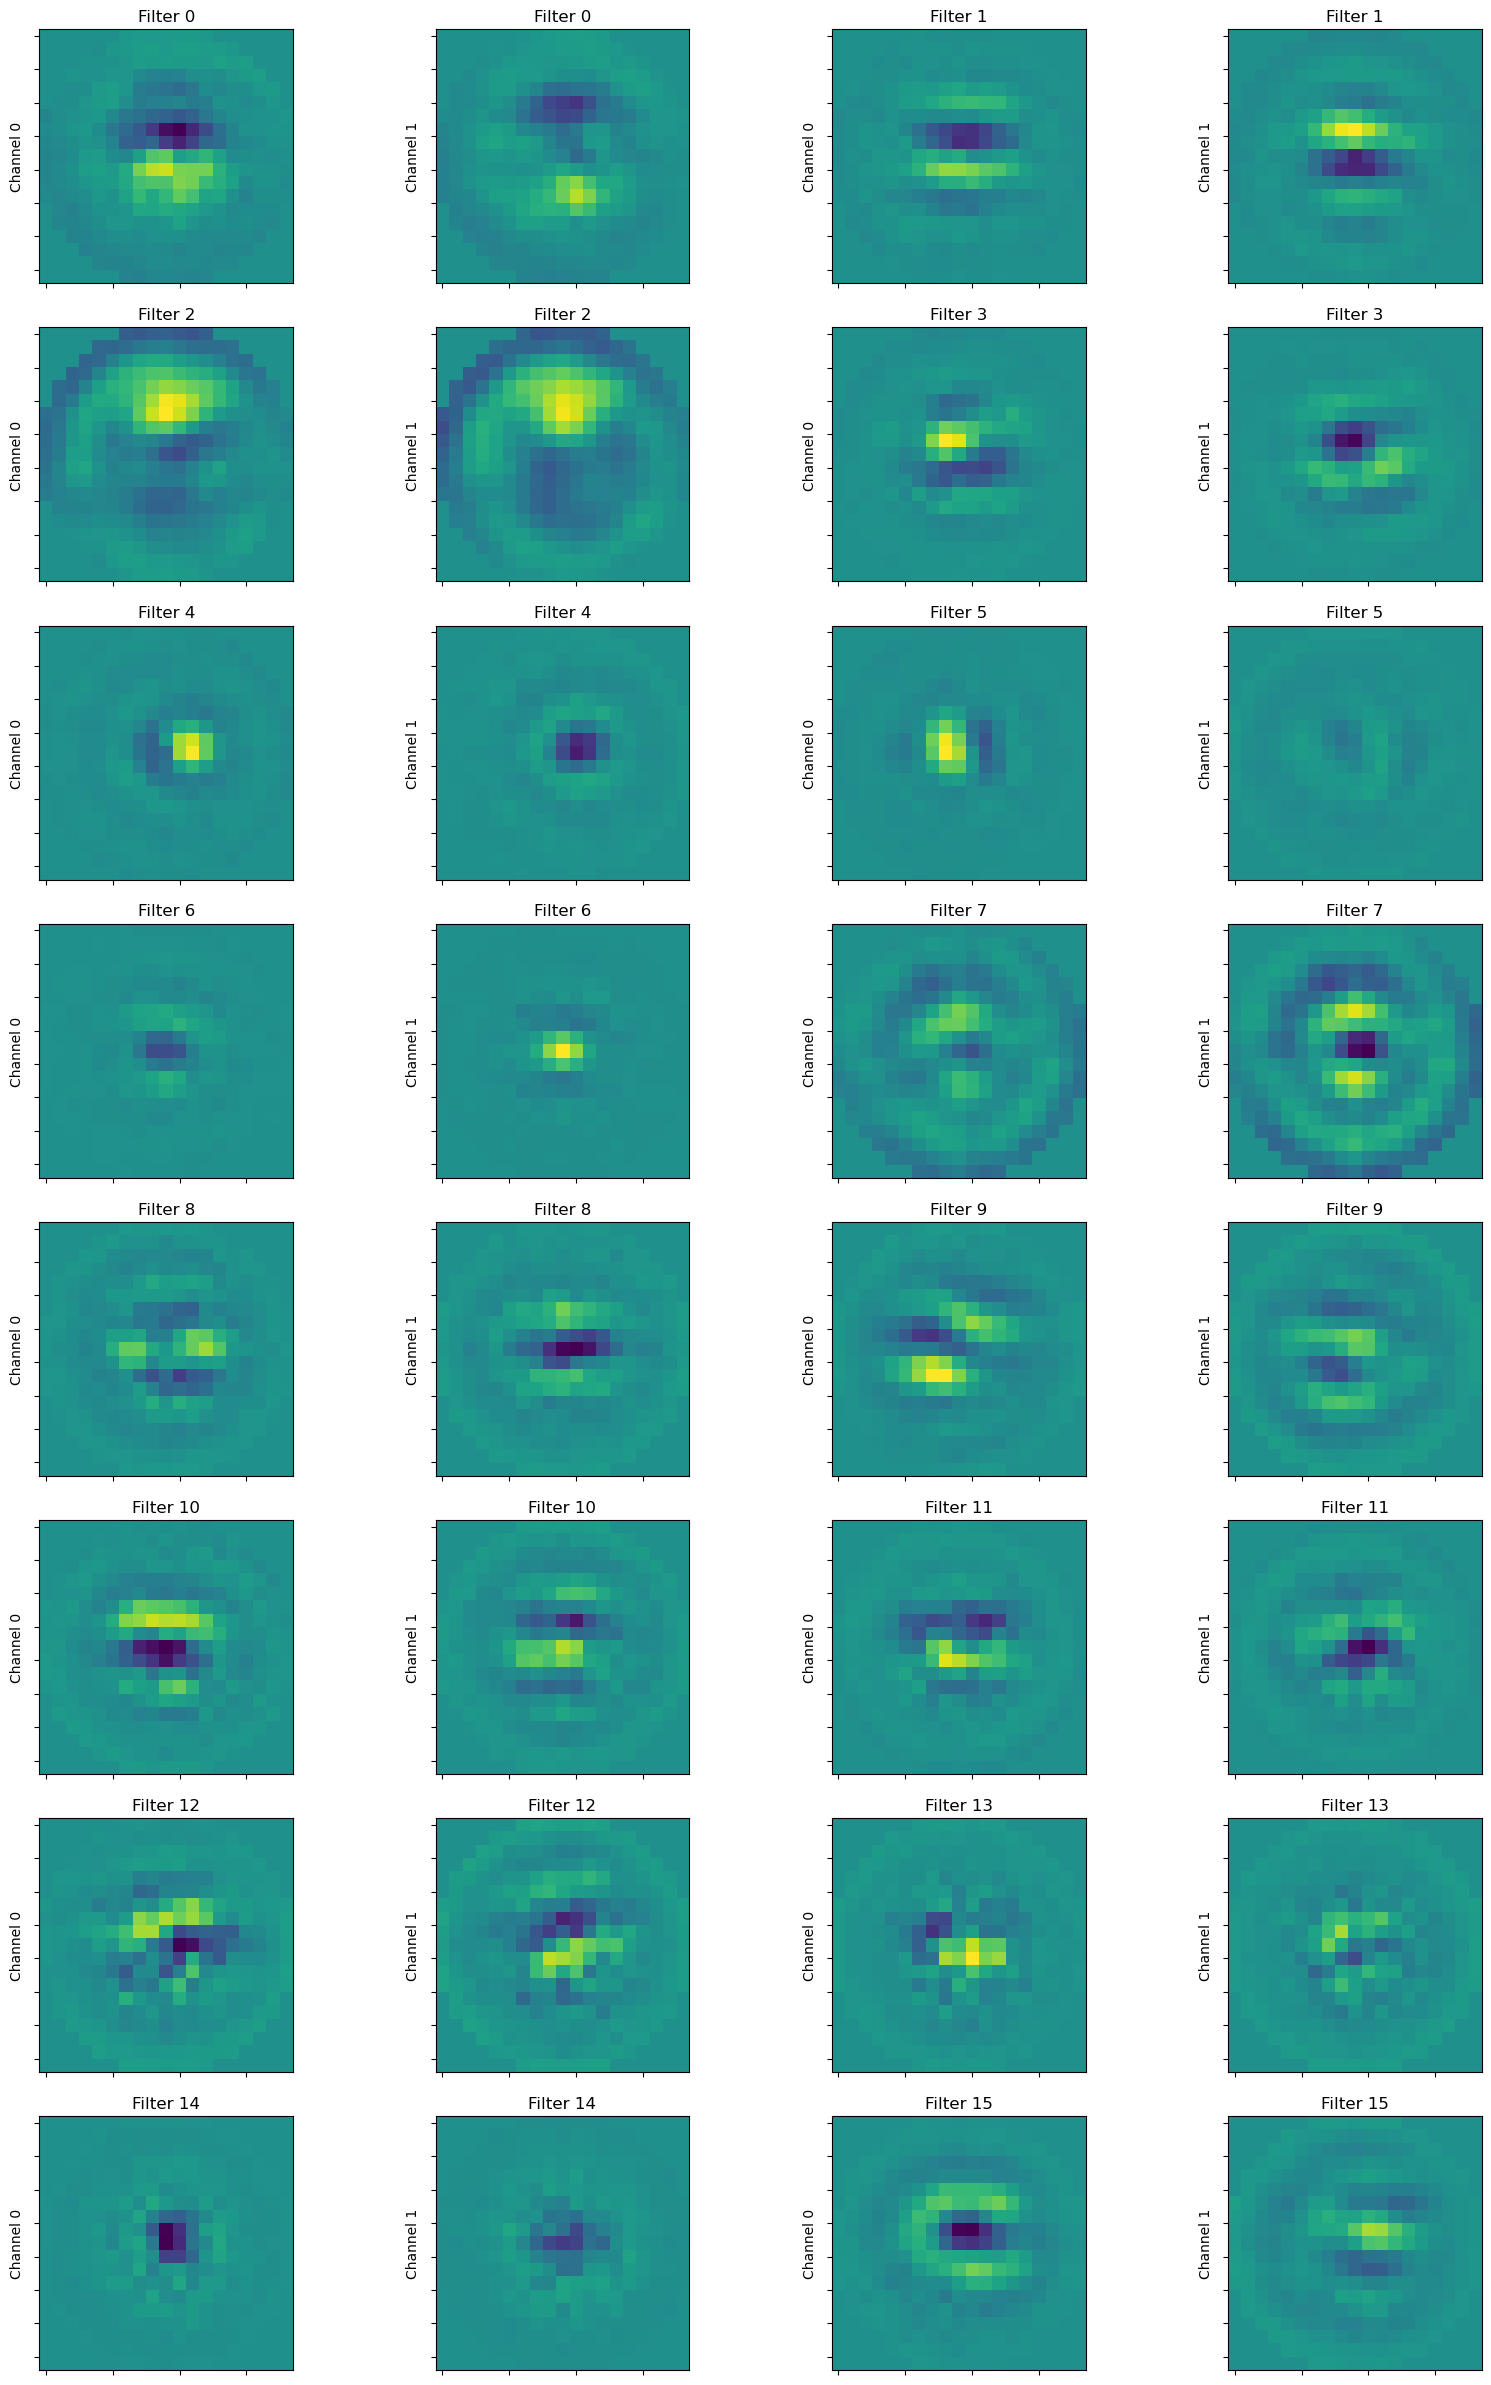

In [39]:
cnn_list[1].plot_filters(ffnet_target=0,layer_target=1)

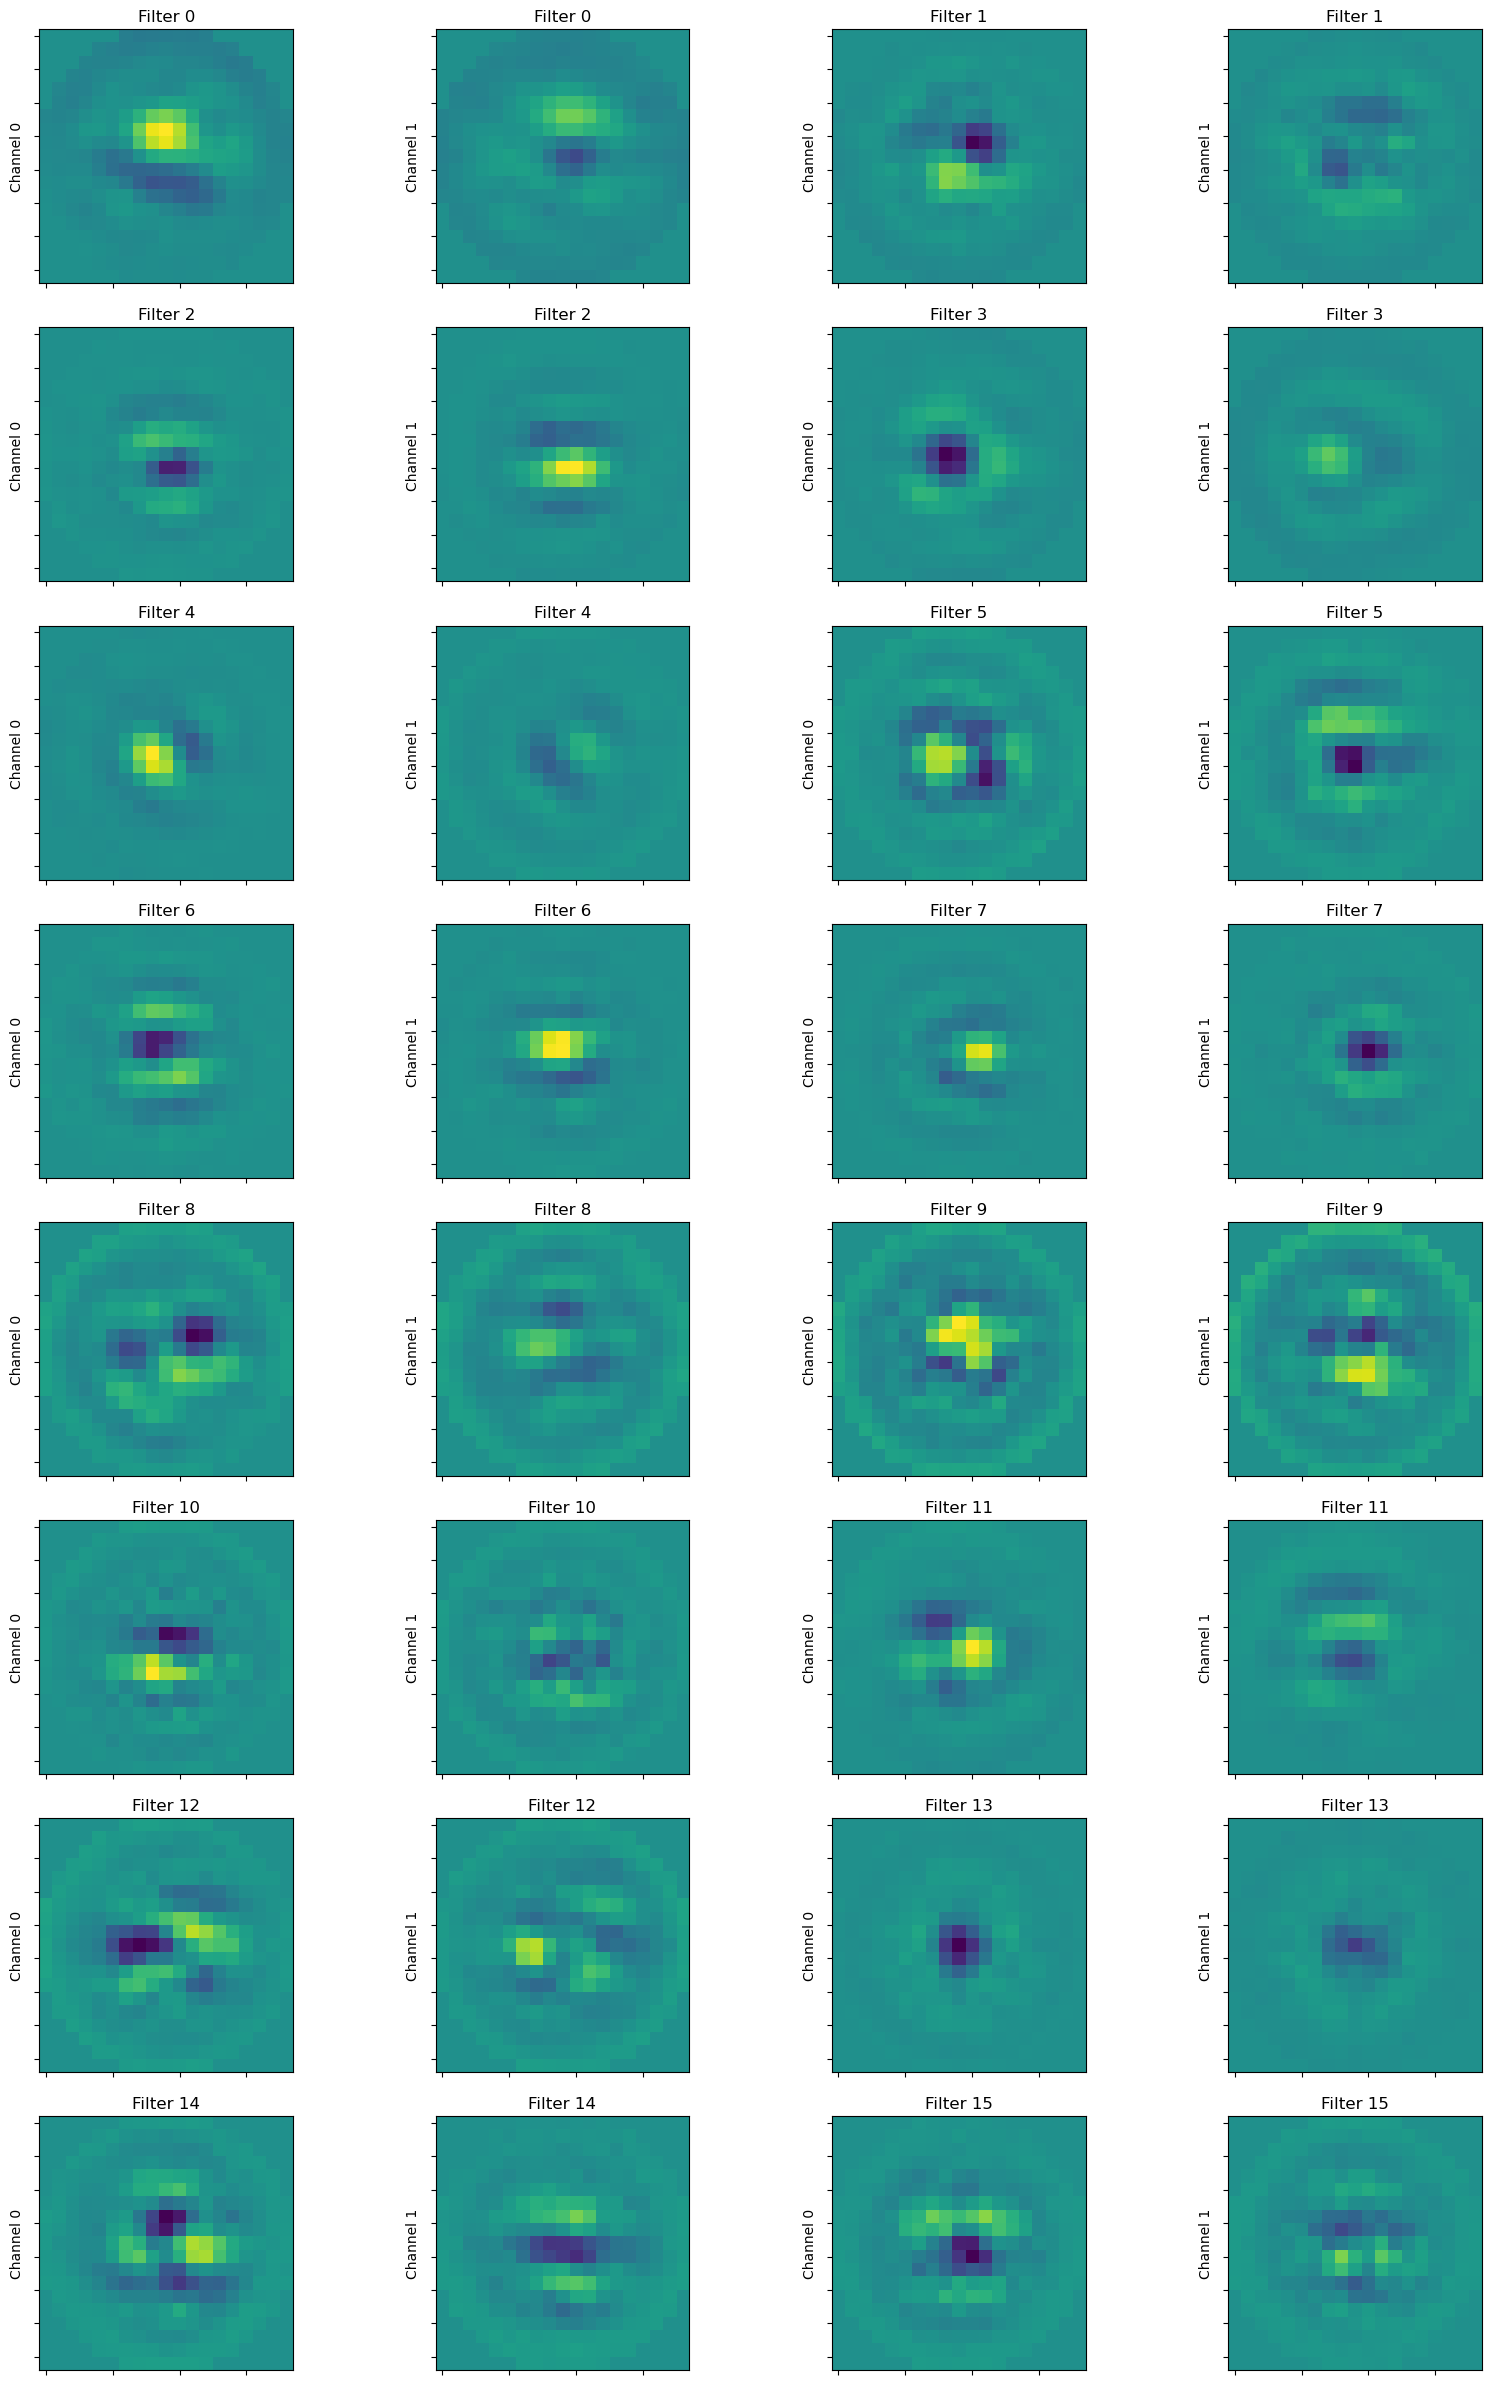

In [40]:
cnn_list[2].plot_filters(ffnet_target=0,layer_target=1)

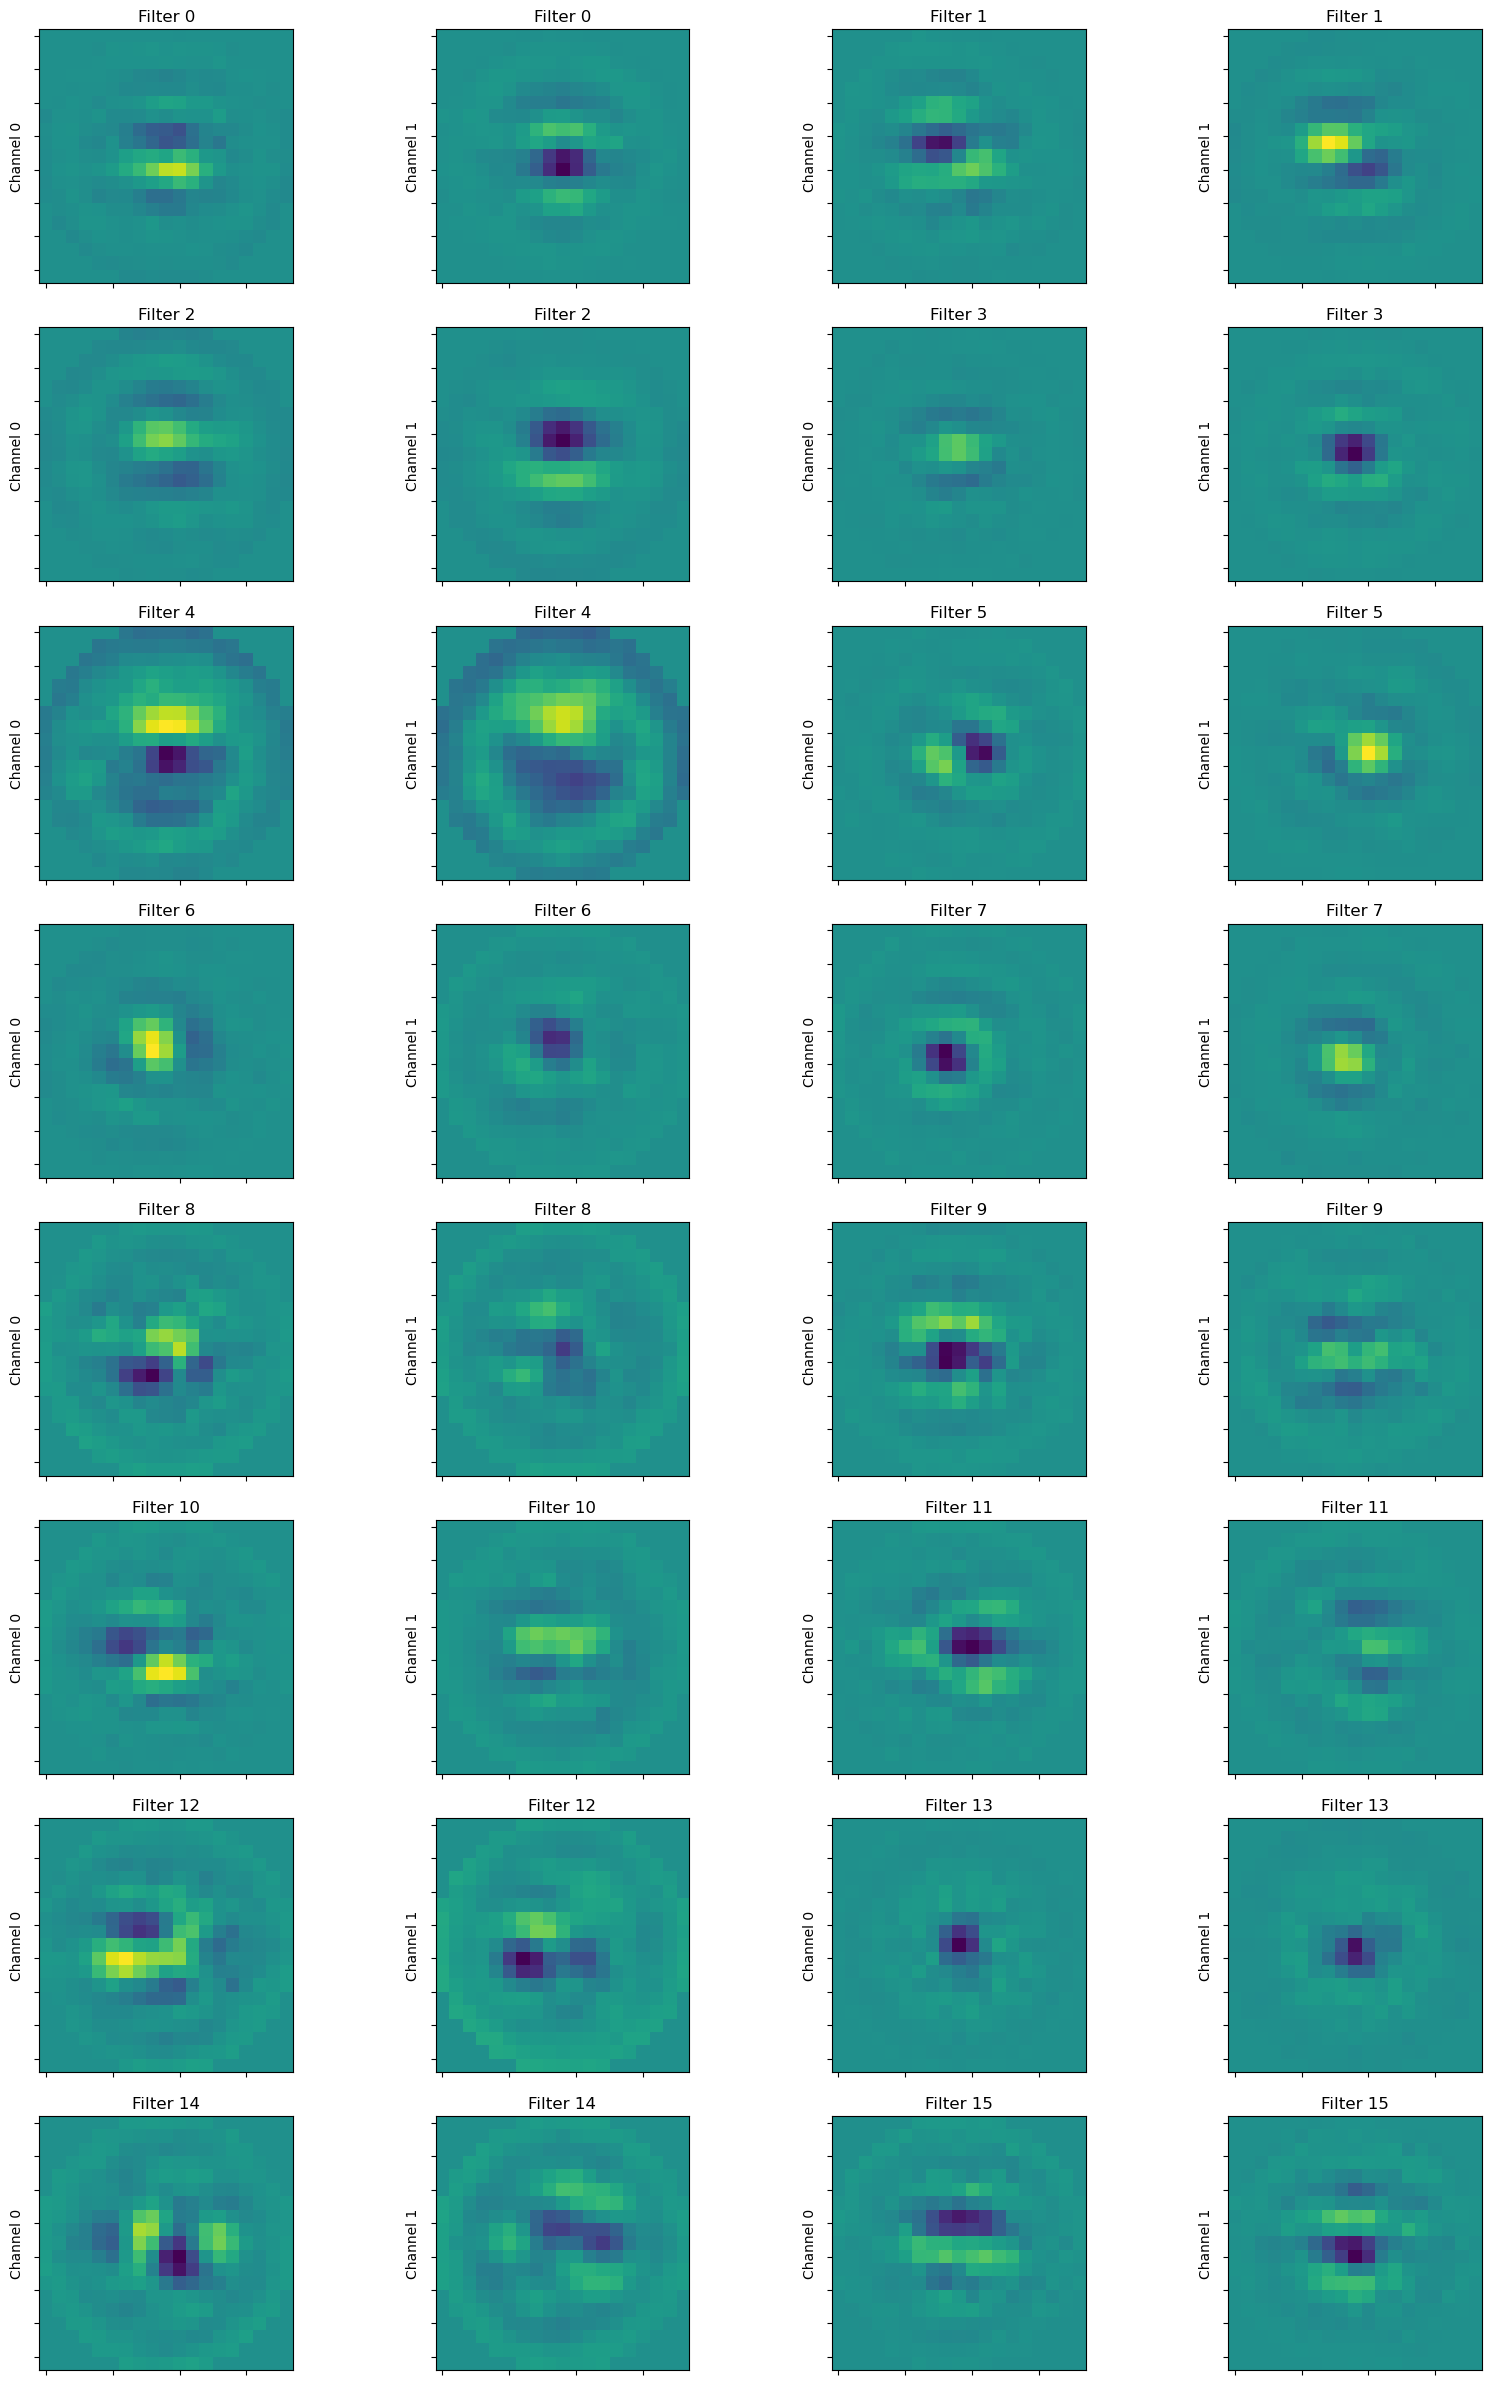

In [41]:
cnn_list[3].plot_filters(ffnet_target=0,layer_target=1)

In [42]:
layer_list = [1,3,4]
best_BC1 = BC.Barcode(cnn_list[0], data, layer_list=layer_list)
print(best_BC1.barcode_idx)
best_BC2 = BC.Barcode(cnn_list[1], data, layer_list=layer_list)
print(best_BC2.barcode_idx)
best_BC3 = BC.Barcode(cnn_list[2], data, layer_list=layer_list)
print(best_BC3.barcode_idx)
best_BC4 = BC.Barcode(cnn_list[3], data, layer_list=layer_list)
print(best_BC3.barcode_idx)

[8, 16, 22, 28, 34, 40]
[8, 16, 22, 28, 34, 40]
[8, 16, 22, 28, 34, 40]
[8, 16, 22, 28, 34, 40]


In [43]:
_, proj_fc1 = spu.t_SNE_analysis(best_BC1, 5, cell_idx_dict)
_, proj_fc2 = spu.t_SNE_analysis(best_BC2, 5, cell_idx_dict)
_, proj_fc3 = spu.t_SNE_analysis(best_BC3, 5, cell_idx_dict)
_, proj_fc4 = spu.t_SNE_analysis(best_BC4, 5, cell_idx_dict)

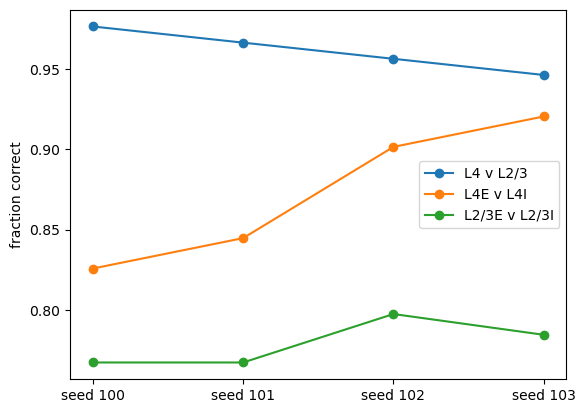

In [44]:
plt.plot([proj_fc1[0],proj_fc2[0],proj_fc3[0],proj_fc4[0]], label='L4 v L2/3', marker='o')
plt.plot([proj_fc1[1],proj_fc2[1],proj_fc3[1],proj_fc4[1]], label='L4E v L4I', marker='o')
plt.plot([proj_fc1[2],proj_fc2[2],proj_fc3[2],proj_fc4[2]], label='L2/3E v L2/3I', marker='o')
labels = ['seed 100', 'seed 101', 'seed 102', 'seed 103']
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.ylabel('fraction correct')
plt.legend()
plt.show()